/opt/Miniconda/envs/jannis_env/lib/python3.11/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)
/opt/Miniconda/envs/jannis_env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


splitting data...
fitting data...
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    1.5s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    3.6s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:    6.7s
[Parallel(n_jobs=20)]: Done 1000 out of 1000 | elapsed:    8.8s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elaps

predicting data...


[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[12-06-2025 13:06:12] [pypickle.pypickle] [INFO] Pickle file saved: [/home/hsp252/Development/HSP_IDS/rfc_balanced.pkl]


saved data
best params: {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 1000}
accurracy: 1.0


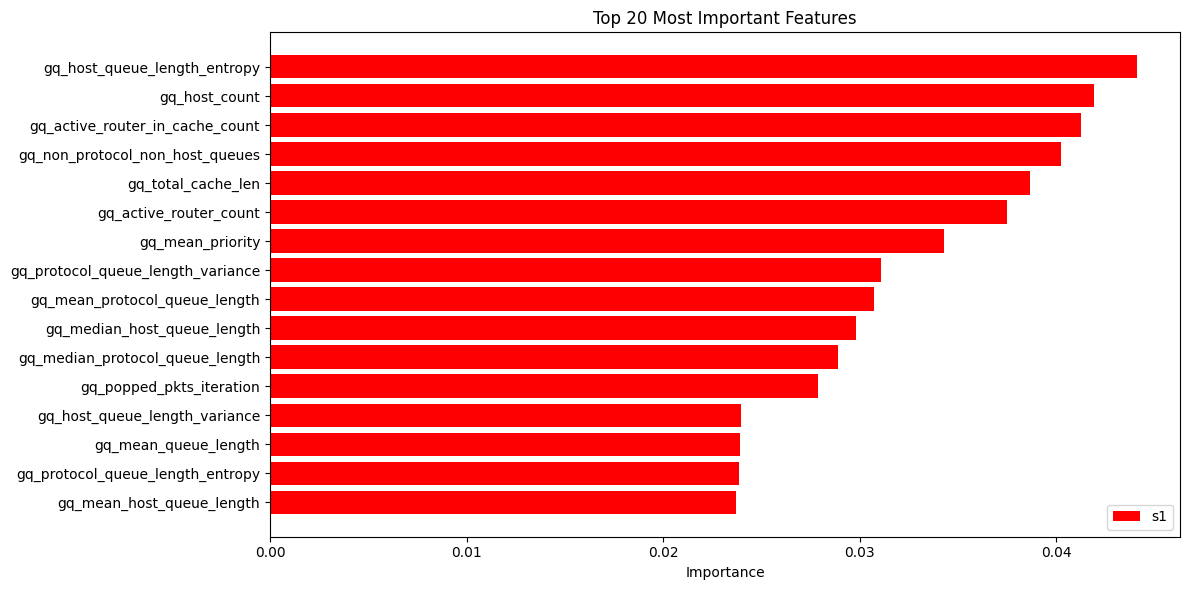

In [ ]:
import data_analysis.data_processing as dp
import data_analysis.data_learning as dl
import gc

# reload module to bypass caching
import importlib
importlib.reload(dp)
importlib.reload(dl)

# paths
test_window_path_home = dp.Path(r'\\?\C:\Users\jannis\Documents\HSP_IDS\Material\Aktuell\2025-02-17_11-14-33_192.168.1.0-normal_1\1554220324.748197-1554220354.748197') # treat it as a long path to avoid path length issues on windows
test_window_path_remote = dp.Path(r'/home/hsp252/nas_mount/hunter.ids.data/hunter.ids.preprocessor/processed_dataframes/angriff/2025-03-04_00-03-20_192.168.1.0-normal_DDoS_1/1556203726.876922-1556203756.876922')

data_set_path = dp.Path(r'/home/hsp252/nas_mount/hunter.ids.data/hunter.ids.preprocessor/processed_dataframes')
ddos_test_path_parquet = dp.Path(r'/home/hsp252/Development/DDoS')

# initiate data
parquet_paths = ['/home/hsp252/Development/intrusion_sorted/DDoS/intrusion_normal_DDoS_10_final.parquet',
                 '/home/hsp252/Development/intrusion_sorted/DoS/intrusion_normal_DoS_1_final.parquet',
                 '/home/hsp252/Development/intrusion_sorted/injection/intrusion_injection_normal1_final.parquet',
                 '/home/hsp252/Development/intrusion_sorted/mitm/intrusion_MITM_normal1_final.parquet',
                 '/home/hsp252/Development/intrusion_sorted/runsomware/intrusion_normal_runsomware1_final.parquet',
                 '/home/hsp252/Development/intrusion_sorted/scanning/intrusion_normal_scanning1_final.parquet',
                 '/home/hsp252/Development/benign/benign_normal_10_final.parquet']
fvs = dp.pd.DataFrame()
labels = dp.pd.DataFrame()
attack_types = ['ddos', 'dos', 'injection', 'mitm', 'runsomware', 'scanning', 'normal']
NR_MIN_ELEMENTS = 27278
NR_MAX_ELEMENTS = 6083416

# get connection-based fvs from parquet, with sample balancing
for i, path in enumerate(parquet_paths):
    fvs_local = dp.read_parquet(path, NR_MIN_ELEMENTS)
    fvs = dp.pd.concat([fvs, fvs_local])
    labels = dp.pd.concat([labels, dp.pd.DataFrame({'attack_type': [attack_types[i]] * fvs_local.shape[0]})])
    del fvs_local
    gc.collect()

# data and program use 9gb with 20 cores in RFC, 46s, no GridSearch
# -> pq.ParquetFile.read() is tremendeously faster and more memory-efficient than pd.read_parquet()!

# # get connection-based fvs from parquet, no sample balancing
# for i, path in enumerate(parquet_paths):
#     fvs_local = dp.read_parquet(path)
#     labels = dp.pd.concat([labels, dp.pd.DataFrame({'attack_type': [attack_types[i]] * fvs_local.shape[0]})])
#     del fvs_local
#     gc.collect()

# # data and program use 46gb of RAM with one core, 55gb with 20 cores in RFC, 1:10h, no GridSearch

# create, train and store rfc
best_rfc, best_params, predictions, accuracy, feature_importances = dl.rfc(fvs, labels)
dl.save_to_pickle(best_rfc, '/home/hsp252/Development/HSP_IDS/rfc_balanced.pkl')

print(f"best params: {best_params}")
print(f"accurracy: {accuracy}")

# plot feature importances
feature_importance_df = dp.pd.DataFrame({'feature': fvs.columns, 'importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
important_features = feature_importance_df['feature'][:20][::-1].to_numpy()
important_features_values = feature_importance_df['importance'][:20][::-1].to_numpy()

s1_cols = dl.get_feature_names_from_csv('/home/hsp252/nas_mount/hunter.ids.data/hunter.ids.preprocessor/processed_dataframes/angriff/2025-02-28_08-41-32_192.168.1.0-normal_backdoor/1556466432.434372-1556466462.434372/s1_general_qs.csv').to_list()
connection_cols = dl.get_feature_names_from_csv('/home/hsp252/nas_mount/hunter.ids.data/hunter.ids.preprocessor/processed_dataframes/angriff/2025-02-28_08-41-32_192.168.1.0-normal_backdoor/1556466432.434372-1556466462.434372/192.168.1.152/connections/1556466432.434372-1556466442.434372/96.0_192.168.1.193_49338.0_192.168.1.152_1880.0/host_data_chunk_full.csv').to_list()
s2_cols = dl.get_feature_names_from_csv('/home/hsp252/nas_mount/hunter.ids.data/hunter.ids.preprocessor/processed_dataframes/angriff/2025-02-28_08-41-32_192.168.1.0-normal_backdoor/1556466432.434372-1556466462.434372/192.168.1.152/s2_selected_qs.csv').to_list()
s3_cols = dl.get_feature_names_from_csv('/home/hsp252/nas_mount/hunter.ids.data/hunter.ids.preprocessor/processed_dataframes/angriff/2025-02-28_08-41-32_192.168.1.0-normal_backdoor/1556466432.434372-1556466462.434372/192.168.1.152/s3_connection_qs.csv').to_list()

s1_mask = [i for i, feature in enumerate(important_features) if feature in s1_cols]
s2_mask = [i for i, feature in enumerate(important_features) if feature in s2_cols]
s3_mask = [i for i, feature in enumerate(important_features) if feature in s3_cols]
connection_mask = [i for i, feature in enumerate(important_features) if feature in connection_cols]

dp.plt.figure(figsize=(12, 6))
if s1_mask:
        dp.plt.barh(important_features[s1_mask], important_features_values[s1_mask], color = 'red', label='s1')
if s2_mask:
        dp.plt.barh(important_features[s2_mask], important_features_values[s2_mask], color = 'blue', label='s2')
if s3_mask:
        dp.plt.barh(important_features[s3_mask], important_features_values[s3_mask], color = 'green', label='s3')
if connection_mask:
        dp.plt.barh(important_features[connection_mask], important_features_values[connection_mask], color = 'orange', label='connection')
dp.plt.xlabel("Importance")
dp.plt.title("Top 20 Most Important Features")
dp.plt.tight_layout()
dp.plt.legend()
dp.plt.show()

# TODO: even amount of samples per attack type
# TODO: store trained and optimized rfc in a pickle-file and test on unseen data